In [9]:
!pip install scikit-learn==1.3.0
from sklearn.metrics import silhouette_score

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from itertools import product

**Q1.** In the following cell load the data (in the file SMDataRefined.csv) to a pandas dataframe, and display the data. Then get the data into a numpy matrix $X$, each row corresponding to a datapoint and each column to a feature, in our case whether a certain token exists ($1$) or not ($0$). Let us denote the number of rows of $X$ by $N$ and the number of columns by $M$.

**About the dataset**: Each row in the dataset refers to a social media post. The first column refers to the number of likes received by each post (standardized between to the interval $[0, 1]$), the columns after that will denote the presence of a certain word (token) in the text of the post. For example, a $1$ in the column "TextToken_life" denotes that the particular post contained the word "life" in it and $0$ otherwise. These will be the features of our dataset. Our aim is to cluster these social media posts based on number of likes and words contained in it.

In [11]:
df = pd.read_csv('SMDataRefined.csv')
print(f"Dataframe Head:\n {df.head()}")

X = df.values
N, M = X.shape
print(f"\nNumber of rows (N): {N}")
print(f"Number of columns (M): {M}")
print(f"\nNumpy Matrix X:\n {X}")


Dataframe Head:
       Likes  TextToken_life  TextToken_joy  TextToken_night  TextToken_heart  \
0  0.285714               0              0                0                0   
1  0.000000               0              0                0                0   
2  0.428571               0              0                0                0   
3  0.071429               0              0                0                0   
4  0.214286               0              0                0                0   

   TextToken_laughter  TextToken_dreams  TextToken_feeling  TextToken_day  \
0                   0                 0                  0              1   
1                   0                 0                  0              0   
2                   0                 0                  0              0   
3                   0                 0                  0              0   
4                   0                 0                  0              0   

   TextToken_like  TextToken_new  
0   

**Q2.** In the following cell create a new function named $\textrm{initMu}$, that takes in two parameters $\textrm{npoints}$ and $\textrm{nclusters}$ and outputs the membership matrix for $\textrm{npoints}$ number of data points and $\textrm{nclusters}$ number of clusters. Recall from the lecture that the membership matrix $U$ of dimension $N \times c$ has the following properties.

1. $0 \leq u_{ij} \leq 1$
2. $\sum\limits_{j = 1}^{c}u_{ij} = 1$ for all $i = 1,2, \cdots, N$

You can do a random initialization. Here $\textrm{npoints} = N$ and $\textrm{nclusters} = c$.

In [12]:
def initMu(npoints, nclusters):
    #TODO fill in the code
    U = np.random.rand(npoints, nclusters)
    U = U / U.sum(axis=1, keepdims=True)
    return U


**Q3.** In the following cell create a function named $\textrm{calculateCenters}$ that computes and returns centers $v_j$, $j = 1, 2, \cdots, c$ (as $c \times M$ matrix) given the data matrix $X$ and the membership matrix $U$. Recall the following update formula for $v_j$ from the lectures.

$v_j = \frac{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1} x_i}{\sum\limits_{i = 1}^N {\left( \frac{u_{ij}}{u_{max}} \right)}^{m_1}}$

Here $u_{max} = max \left(u_{1j}, u_{2j}, \cdots, u_{Nj} \right)$ and $m_1 \in [1, \infty)$ is a hyperparameter we discussed in class, and will be passed in as a parameter to the function.

The most efficient way to do this computation is by matrix multiplications. Try to find the appropriate matrix multiplication. You may need to transpose certain matrices.

In [13]:
def calculateCenters(X, U, m):
    #TODO fill in the code
    u_max = np.max(U, axis=0)
    U_normalized = U / u_max
    U_normalized_m = U_normalized ** m
    numerator = np.dot(U_normalized_m.T , X)

    denominator = np.sum(U_normalized.T, axis=1, keepdims=True)
    centers = numerator / denominator  # (c x M) / (c x 1) = (c x M)
    return centers

**Q4.** In the following cell create a function named $\textrm{updateMu}$ that updates the membership matrix $U$ given the data matrix $X$ and the $\textrm{centers}$. Recall the following update formula for $u_{ij}$ from the lectures.

$u_{ij} = {\left[ \sum\limits_{l = 1}^c { \left( \frac{d_{ij}}{d_{il}} \right)}^{\frac{2}{m_2 - 1}} \right]}^{-1}$
where $d_{ij}$ is the distance between the $i$th data point and the $j$th cluster center. $m_2 \in (1, \infty)$ is another hyperparameter that is passed into the function.

To compute distances sklearn.metrics.pairwise.pairwise_distances could be useful. For these computations, try to avoid for loops as much as possible and use the tools offered by numpy for matrix manipulations for example such as numpy.tile.

The function should finally return the updated $U$ matrix.

In [14]:
from sklearn.metrics import pairwise_distances
def updateMu(X, centers, m2):
    # Calculate pairwise distances
    distances = pairwise_distances(X, centers)
    # Update the membership matrix
    power = -1 / (m2 - 1)
    U_new = distances ** power
    # Normalize across clusters to ensure row sums equal 1
    U_new = U_new / np.sum(U_new, axis=1, keepdims=True)
    return U_new

**Q5.** Use following cell to create a function called $\textrm{fuzzyClustering}$ that takes in a data matrix $X$ the number of clusters $\textrm{nclusters}$, $m_1$, $m_2$ hyperparameters and then returns a membership matrix $U$ and nclusters number of centers for each cluster as a matrix whose rows will correspond to the centers. Recall that the fuzzy clustering algorithm,

1. Initialize the membership matrix $U$
Repeat the following steps while max iterations (maxIter) reached or change in norm of $U$ is greater than a specified tolerance (tol).
2. Compute cluster centers
3. Update membership matrix

The function you create should be able to compute the norm between the $U$ matrices from consecutive iterations and plot a graph depicting the variation of the change in norm of $U$ against the number of iterations.

In [15]:
def fuzzyClustering(X, nclusters, m1, m2, maxIter=100, tol=1e-4, plot_graph=False):
    N, M = X.shape
    U = initMu(N, nclusters)
    norms = []

    for iteration in range(maxIter):
        centers = calculateCenters(X, U, m1)
        U_new = updateMu(X, centers, m2)

        # Calculate the change in norm between consecutive U matrices
        norm_diff = np.linalg.norm(U_new - U)
        norms.append(norm_diff)

        if norm_diff < tol:
            break

        U = U_new

    if plot_graph:
        # Plot the norm differences only if plot_graph is True
        plt.plot(norms)
        plt.xlabel("Iterations")
        plt.ylabel("Change in Norm of U")
        plt.title("Change in Norm of U vs Iterations")
        plt.show()

    return U, centers


**Q6.** Run the fuzzyClasssification algorithm with different hyperparameters $m_1, m_2, \textrm{nclusters}$, note the plot of $U$-norm difference against the number of iterations. <font color='blue'>What can you say about it?</font>

Now lets use the fuzzy membership to find some crisp cluster labelling $\textrm{yfuzzy}$ to for each data point. For a given datapoint you'll assign the cluster labelling by looking at which cluster assigns the largest membership value. numpy.argmax function would be useful in this case. Again avoid for loops.

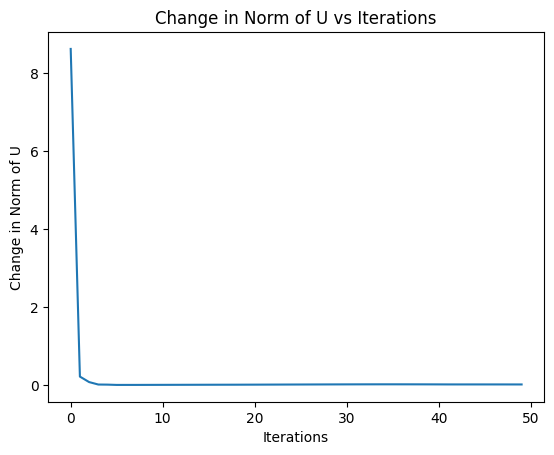

In [16]:
def getCrispLabels(U):
    # Assign labels based on the maximum membership value for each data point
    yfuzzy = np.argmax(U, axis=1)
    return yfuzzy


U_final, final_centers = fuzzyClustering(X, 3, 1.5, 2.0,maxIter=50, tol=1e-4, plot_graph=True)
yfuzzy = getCrispLabels(U_final)


**Q7.** The Silhoutte score is a measure of how well the clustering has been done, the closer the score to $1.0$ the better the clustering. Refer to sklearn.metrics.silhouette_score. Determine the best choice of hyperparameters $m_1, m_2, \textrm{nclusters}$ through a grid search based on the silhoutte score as the evaluation metric. <font color='blue'>Report the best combination of hyperparameters.</font> For the grid search try $m_1 = 1.0, 1.2, \cdots, 3.0$, $m_2 = 1.2, 1.4, \cdots, 3.0$, $\textrm{nclusters} = 2, 3, \cdots, 15$.

In [17]:
from sklearn.metrics import silhouette_score

def gridSearch(X):
    best_score = -1
    best_params = None
    best_U = None
    best_centers = None

    m1_values = np.arange(1.0, 3.2, 0.2)
    m2_values = np.arange(1.2, 3.2, 0.2)
    nclusters_values = range(2, 16)

    for m1 in m1_values:
        for m2 in m2_values:
            for nclusters in nclusters_values:
                U, centers = fuzzyClustering(X, nclusters, m1, m2, maxIter=50, tol=1e-4)
                labels = getCrispLabels(U)
                score = silhouette_score(X, labels)

                if score > best_score:
                    best_score = score
                    best_params = (m1, m2, nclusters)
                    best_U = U
                    best_centers = centers

    print(f"Best m1, m2, nclusters: {best_params}, Silhouette Score: {best_score}")
    return best_params, best_U, best_centers


best_params, best_U, best_centers = gridSearch(X)


Best m1, m2, nclusters: (2.9999999999999996, 1.9999999999999998, 2), Silhouette Score: 0.5217409482036669


**Q8.** For the best combination of hyperparameters run the following visualization function with different values for $0 \leq f_1 < f_2 < \textrm{nclusters}$. <font color='blue'>What do you see? Explain the purpose of the code and what you would expect through this?</font>

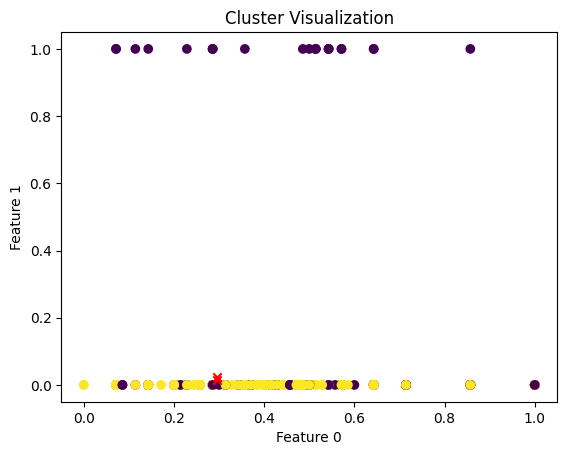

In [18]:
def visualizeClusters(X, U, centers, f1, f2):
    plt.scatter(X[:, f1], X[:, f2], c=getCrispLabels(U), cmap='viridis')
    plt.scatter(centers[:, f1], centers[:, f2], c='red', marker='x')
    plt.xlabel(f"Feature {f1}")
    plt.ylabel(f"Feature {f2}")
    plt.title("Cluster Visualization")
    plt.show()

visualizeClusters(X, best_U, best_centers, 0, 1)


Select Clusters for Visualization:

Choose two clusters
𝑓
1
f1 and
𝑓
2
f2 such that
0
<
𝑓
1
<
𝑓
2
<
nclusters
0<f1<f2<nclusters. These clusters will be compared visually.
The idea is to project the data points onto a 2D plane where each axis corresponds to one of these clusters.
Compute Memberships for Selected Clusters:

For each data point, extract the membership values associated with clusters
𝑓
1
f1 and
𝑓
2
f2.
These membership values will serve as the coordinates for plotting the data points.
Plot the Data Points:

Create a scatter plot where each data point is represented by its membership to cluster
𝑓
1
f1 on the x-axis and to cluster
𝑓
2
f2 on the y-axis.
Use different colors or markers to distinguish between data points that predominantly belong to different clusters.
Interpret the Plot:

Cluster Separation: If the clusters are well-separated, you would expect data points to form distinct groups in the plot.
Overlap: If the clusters overlap, the data points might be spread out more uniformly across the plot, indicating that some points belong to both clusters with similar degrees of membership.
Purpose: This visualization helps in understanding the fuzzy nature of the clustering, showing how data points are shared between clusters.

**Q9.** Load (to a pandas dataframe) the actual dataset (SMData.csv) from which the previous dataset was cleaned out. Match each entry in this dataset with the labels you found out through clustering using the best combination of hyperparameters. Go through a few of those clustered entries and notice any patterns (or common sentiment) in the text (the "Text" column of this dataset) of each entry within clusters vs outside the clusters. The label of the $i$th entry in the dataset $= \textrm{yfuzzy}[i]$. <font color='blue'>Explain any observations. Based on your observations, is the clustering successful?</font>

In [19]:
def analyzeOriginalData(original_file, yfuzzy):
    df = pd.read_csv(original_file)
    if len(yfuzzy) != len(df.index):
      yfuzzy = pd.Series(yfuzzy, index=df.index[:100])

    df['Cluster_Label'] = yfuzzy
    print(df.head())  # Display first few rows with cluster labels

    # Analyze patterns in text column within clusters
    for cluster in np.unique(yfuzzy):
        print(f"\nCluster {cluster}:")
        print(df[df['Cluster_Label'] == cluster]['Text'].head(5))  # Display sample texts in this cluster

# Example usage:
analyzeOriginalData('SMData.csv', yfuzzy)


   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                                Text    Sentiment  \
0   Enjoying a beautiful day at the park!        ...   Positive     
1   Traffic was terrible this morning.           ...   Negative     
2   Just finished an amazing workout! 💪          ...   Positive     
3   Excited about the upcoming weekend getaway!  ...   Positive     
4   Trying out a new recipe for dinner tonight.  ...   Neutral      

             Timestamp            User     Platform  \
0  2023-01-15 12:30:00   User123          Twitter     
1  2023-01-15 08:45:00   CommuterX        Twitter     
2  2023-01-15 15:45:00   FitnessFan      Instagram    
3  2023-01-15 18:20:00   AdventureX       Facebook    
4  2023-01-15 19:55:00   ChefCook        Instagram    

                                     Hashtags  Retweets  Likes     

Unsuccessful Clustering: The posts within each cluster appear random or do not share any noticeable commonalities, the clustering might not have been effective, suggesting the need for further tuning of hyperparameters or possibly reconsidering the features used for clustering.